# *Compute Signal-to-Noise Ratio (SNR) of BERT layers with Spectrum*
*(And select top-50% and top-25% high-SNR layers across 3 BERT-based models)*

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive
!git clone https://github.com/Anjaas85/Spectrum-Guided-Model-Merging.git
%cd Spectrum-Guided-Model-Merging/

In [ ]:
!git clone https://github.com/cognitivecomputations/spectrum.git
%cd spectrum
!pip install -r requirements.txt

In [ ]:
!pip install -q textattack transformers accelerate bitsandbytes scipy pandas matplotlib

Spectrum script uses a library to draw a TUI ($\texttt{prompt_toolkit}$) which is not supported by Colab notebooks.

**To avoid crash (EOFError), run the following cell**:
It replaces the interactive UI lines with hardcoded defaults: batch_size = 4 and calling modifier.get\_weight\_types() to retrieve all available layers automatically

In [ ]:
import os

file_path = 'spectrum.py'
with open(file_path, 'r') as f:
    code = f.read()
#bypass UI batch size
target_batch_ui = 'batch_size = input_dialog(title="Batch Size", text="Enter the batch size:").run()'
if target_batch_ui in code:
    code = code.replace(target_batch_ui, 'batch_size = 4  #patched')
    print("Patched batch size")

#bypass UI weight (select all weights)
target_weight_ui = 'selected_weight_types = modifier.interactive_select_weights()'
if target_weight_ui in code:
    code = code.replace(target_weight_ui, 'selected_weight_types = modifier.get_weight_types()  # patched')
    print("Patched weight selection")

with open(file_path, 'w') as f:
    f.write(code)

print("Done (bypassed UI)")

**Run the following cell to compute the Signal-to-Noise ratio** for each layer of each of the 3 BERT-based models using Spectrum, and save the results in a csv file

In [ ]:
import json
import glob
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


MODELS_TO_TEST = [
    "google-bert/bert-base-uncased",
    "textattack/bert-base-uncased-SST-2",
    "textattack/bert-base-uncased-ag-news",
    "textattack/bert-base-uncased-MNLI"
]

PRIMARY_PERCENT = 50
SECONDARY_PERCENT = 25

def get_layer_statistics_raw(json_file, model_name):
    with open(json_file, 'r') as f:
        raw_data = json.load(f)
    layer_groups = {}
    regex = r'\.(layers?|block|h)\.(\d+)\.'
    for module_name, data in raw_data.items():
        snr_val = data.get('snr', 0)
        if not np.isfinite(snr_val): continue
        match = re.search(regex, module_name)
        if match:
            idx = int(match.group(2))
            layer_groups.setdefault(idx, []).append(snr_val)

    return [{"Model": model_name, "Layer_Index": k, "SNR": np.mean(v)}
            for k, v in layer_groups.items()]


all_models_data = []

for model_name in MODELS_TO_TEST:
    !python spectrum.py --model-name {model_name} --top-percent 100 > /dev/null 2>&1
    list_of_files = glob.glob('model_snr_results/*.json')
    if not list_of_files: continue
    latest_file = max(list_of_files, key=os.path.getctime)
    all_models_data.extend(get_layer_statistics_raw(latest_file, model_name))
    os.remove(latest_file)

df = pd.DataFrame(all_models_data)

df['Is_Primary'] = False
df['Is_Secondary'] = False

for model in df['Model'].unique():
    mask = df['Model'] == model
    subset = df[mask]

    sorted_snrs = subset.sort_values("SNR", ascending=False)['SNR'].values
    n_layers = len(sorted_snrs)

    if n_layers > 0:
        cutoff_primary = sorted_snrs[int(np.ceil(n_layers * (PRIMARY_PERCENT/100.0))) - 1]
        cutoff_secondary = sorted_snrs[int(np.ceil(n_layers * (SECONDARY_PERCENT/100.0))) - 1]

        df.loc[mask & (df['SNR'] >= cutoff_primary), 'Is_Primary'] = True
        df.loc[mask & (df['SNR'] >= cutoff_secondary), 'Is_Secondary'] = True

output_filename = "../bert_layer_snr_values.csv"

df.to_csv(output_filename, index=False)

print(f"dataFrame saved to: {output_filename}")

**Run the following cell to generate a bar plot of layer SNRs** across the 3 BERT-base models (plus the BERT base model itself) to compare them side by side. (like the one we included in *Figure 1.* in the report).

Figure saved to ../bert_layer_SNR_plot.png


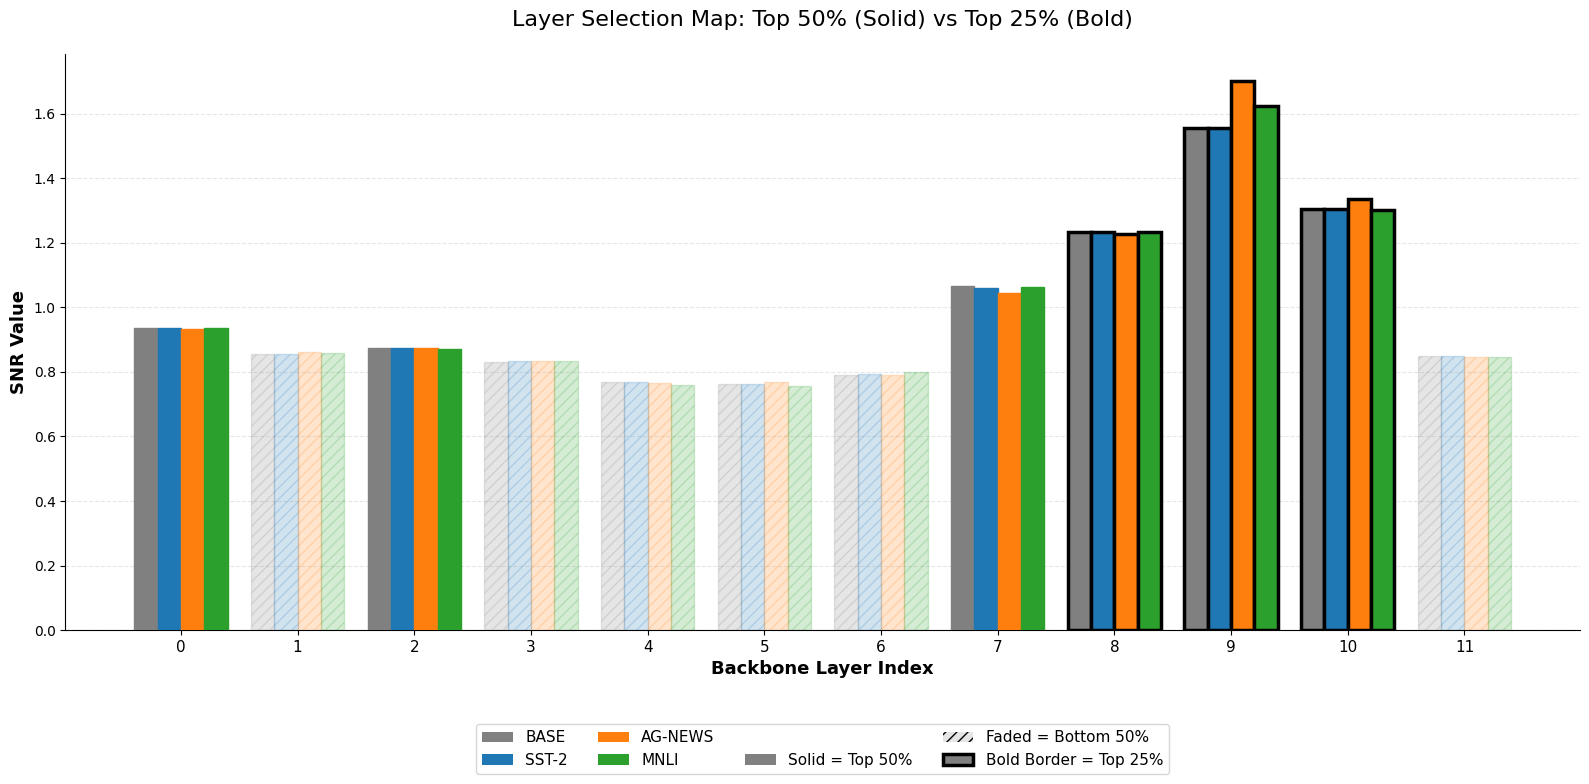

In [10]:
plt.figure(figsize=(16, 8))

layers = sorted(df['Layer_Index'].unique())
models = df['Model'].unique()
x = np.arange(len(layers))
width = 0.20
multiplier = 0

model_colors = ['gray', '#1f77b4', '#ff7f0e', '#2ca02c']

for i, model in enumerate(models):
    subset = df[df['Model'] == model].sort_values("Layer_Index")
    offset = width * multiplier
    base_color = model_colors[i]
    short_name = model.split('/')[-1].replace('bert-base-uncased-', '').upper()

    for idx, row in subset.iterrows():
        layer_x = x[int(row['Layer_Index'])] + offset

        # Top 50% style
        bar_alpha = 1.0 if row['Is_Primary'] else 0.2
        bar_hatch = '' if row['Is_Primary'] else '///'

        # Top 25% style
        if row['Is_Secondary']:
            current_linewidth = 2.5
            current_edgecolor = 'black'
        else:
            current_linewidth = 1.0
            current_edgecolor = base_color

        plt.bar(layer_x, row['SNR'], width,
                color=base_color,
                alpha=bar_alpha,
                hatch=bar_hatch,
                edgecolor=current_edgecolor,
                linewidth=current_linewidth,
                zorder=3)

    plt.bar([0], [0], width, color=base_color, label=f"{short_name}", alpha=1.0)
    multiplier += 1

final_x_ticks = x + width * (len(models) - 1) / 2
plt.xticks(final_x_ticks, layers, fontsize=11)
plt.yticks(fontsize=10)
plt.xlabel("Backbone Layer Index", fontsize=13, fontweight='bold')
plt.ylabel("SNR Value", fontsize=13, fontweight='bold')
plt.title(f"Layer Selection Map: Top {PRIMARY_PERCENT}% (Solid) vs Top {SECONDARY_PERCENT}% (Bold)", fontsize=16, pad=20)

legend_elements = [Patch(facecolor=c, label=m.split('/')[-1]
                   .replace('bert-base-uncased-', '')
                   .replace('bert-base-uncased', 'BASE')
                   .upper())
                   for c, m in zip(model_colors, models)]

legend_elements.append(Line2D([0], [0], color='black', lw=0, label='')) # Spacer
legend_elements.append(Patch(facecolor='gray', alpha=1.0, label=f'Solid = Top {PRIMARY_PERCENT}%'))
legend_elements.append(Patch(facecolor='gray', alpha=0.2, hatch='///', label=f'Faded = Bottom {100-PRIMARY_PERCENT}%'))
legend_elements.append(Patch(facecolor='gray', edgecolor='black', linewidth=2.5, label=f'Bold Border = Top {SECONDARY_PERCENT}%'))

plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

output_filename = '../bert_layer_SNR_plot.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"Figure saved to {output_filename}")

plt.show()